In [14]:
import torch
import chirho.contrib.experiments.closed_form as cfe
from chirho.contrib.experiments.decision_optimizer import DecisionOptimizer
import pyro.distributions as dist
from torch import tensor as tnsr
from torch import Tensor as Tnsr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from scipy.optimize import minimize
import chirho.contrib.compexp as ep
import pyro
from typing import Callable, List, Tuple
from collections import OrderedDict
from pyro.infer.autoguide.initialization import init_to_value

In [15]:
class CostRiskProblem:
    Sigma: Tnsr
    Q: Tnsr
    q: Tnsr
    theta0: Tnsr
    c: Tnsr
    rstar: Tnsr
    theta0_init_dist: Tnsr

    @property
    def n(self):
        return self.Sigma.shape[0]

    def ana_loss(self, theta):
        return -cfe.full_ana_obj(theta=theta, Sigma=self.Sigma, Q=self.Q, c=self.c)

    def ana_loss_grad(self, theta):
        theta = theta.detach().requires_grad_(True)
        loss = self.ana_loss(theta)
        grad = torch.autograd.grad(loss, theta)[0]
        return grad

    @staticmethod
    def cost(theta):
        return theta @ theta

    def scaled_risk(self, theta, z):
        return self.c * cfe.risk_curve(theta=theta, Q=self.Q, z=z)

    def model(self):
        return pyro.sample('z', dist.MultivariateNormal(loc=torch.zeros(self.n).double(), covariance_matrix=self.Sigma))

In [16]:
def generate_problem(q: float, n: int, rstar: float, theta0_rstar_delta: float) -> CostRiskProblem:
    """
    Generate a cost/risk minimization problem. Cost, in this case is simply ||theta||**2, while the risk
     is the expecation of the risk curve with respect to the distribution p(z) = N(0, Sigma).
    The risk curve is an unnormalized Gaussian with mean theta and covariance Q, which will have a covariance
     inducing a similar-sized curve to one with an I*q covariance.

    :param q: The stdev of the risk curve.
    :param n: The dimensionality of the problem.
    :param rstar: The distance to which theta should converge to solve the problem. This allows for precise experimental
     control over how far into the tails of p(z) the optimization should position the risk curve.
    :param theta0_rstar_delta: The delta from rstar that theta should be (randomly) initialized to. This will initialize
     theta to sit on a hypersphere of radius rstar + theta0_rstar_delta.
    :return:
    """

    q, rstar, theta0_rstar_delta = map(lambda x: tnsr(x) if not isinstance(x, Tnsr) else x, [q, rstar, theta0_rstar_delta])

    Sigma = dist.Wishart(covariance_matrix=torch.eye(n), df=tnsr(n+3)).sample()
    if torch.linalg.det(Sigma) <= 0.7:  # If too singular, try again recursively.
        return generate_problem(q, n, rstar, theta0_rstar_delta)
    Sigma = cfe.rescale_cov_to_unit_mass(Sigma)

    Q = dist.Wishart(covariance_matrix=torch.eye(n), df=tnsr(n+3)).sample()
    if torch.linalg.det(Q) <= 0.5:
        return generate_problem(q, n, rstar, theta0_rstar_delta)
    Q = cfe.rescale_cov_to_unit_mass(Q) * q

    c = cfe.compute_ana_c(q, rstar, n)

    # Generate a uniformly random direction on the unit hypersphere.
    theta0 = dist.Normal(torch.zeros(n), torch.ones(n)).sample()
    # Rescale to the desired radius.
    theta0 = theta0 / theta0.norm() * (rstar + theta0_rstar_delta)
    # And transform according to Sigma. This ensures that the initial theta does indeed sit on the rstar + theta0_rstar_delta
    #  contour of p(z), as opposed to just the unit normal.
    theta0 = torch.linalg.cholesky(Sigma) @ theta0

    problem = CostRiskProblem()
    problem.Sigma = Sigma.double()
    problem.Q = Q.double()
    problem.q = q.double()
    problem.theta0 = theta0.double()
    problem.c = c.double()
    problem.rstar = rstar.double()
    problem.theta0_init_dist = (theta0_rstar_delta + rstar).double()

    # Gradcheck the problem's analytical loss.
    theta0 = problem.theta0.detach().requires_grad_(True)
    torch.autograd.gradcheck(problem.ana_loss, theta0)

    return problem

In [17]:
def opt_ana_with_scipy(problem: CostRiskProblem):
    traj = [problem.theta0.detach().numpy()]

    def callback(xk):
        traj.append(xk)

    def numpy_loss(theta: np.ndarray):
        return problem.ana_loss(tnsr(theta).double()).numpy()

    def numpy_grad(theta: np.ndarray):
        return problem.ana_loss_grad(tnsr(theta).double()).numpy()

    theta0 = problem.theta0.numpy()
    res = minimize(numpy_loss, theta0, method='BFGS', callback=callback, jac=numpy_grad, tol=1e-6)

    assert np.allclose(traj[-1], res.x)

    return np.array(traj)

In [18]:
def opt_opt_tabi_with_scipy(problem: CostRiskProblem):
    """
    This uses TABI with an optimal guide to get exact estimates of the gradient, acts as a baseline test.
    """
    traj = [problem.theta0.detach().numpy()]

    def callback(xk):
        traj.append(xk)

    def numpy_loss(theta: np.ndarray):
        theta = tnsr(theta).double()

        mu_star, Sigma_star = cfe.optimal_tabi_proposal_nongrad(theta, problem.Q, problem.Sigma)

        # When used with guides, expectations require the dict return. Is a TODO FIXME d78107gkl.
        def opt_guide():
            return OrderedDict(z=pyro.sample('z', dist.MultivariateNormal(mu_star, Sigma_star)))

        def model():
            return OrderedDict(z=problem.model())

        risk = ep.E(
            f=lambda s: cfe.risk_curve(theta, problem.Q, s['z']).squeeze(),
            name='risk',
            guide=opt_guide
        )
        risk._is_positive_everywhere = True

        cost = ep.C(theta @ theta, requires_grad=True) + ep.C(problem.c) * risk

        eh = ep.ImportanceSamplingExpectationHandler(num_samples=1)
        eh.register_guides(cost, model, auto_guide=None)

        with eh:
            return cost(model).detach().clone().numpy()

    theta0 = problem.theta0.numpy()
    res = minimize(numpy_loss, theta0, method='BFGS', callback=callback, tol=1e-6)

    assert np.allclose(traj[-1], res.x)

    return np.array(traj)

In [19]:
def sgd_convergence_check(traj: List[np.ndarray], recent=500, less_recent=1000, atol=1e-2):
    last_recent = np.array(traj[-recent:])
    last_less_recent = np.array(traj[-less_recent:-recent])
    return np.allclose(last_recent.mean(axis=0), last_less_recent.mean(axis=0), atol=atol)

In [20]:
def do_loop(pref: str, num_steps, adjust_grads_, do: DecisionOptimizer, theta: torch.Tensor, burnin: int = 0):
    traj = [theta.detach().clone().numpy()]
    grad_ests = []

    num_steps += burnin

    for i in range(num_steps):
        print(f"{pref} {i:05d}/{num_steps}", end="\r")
        grad_est = do.estimate_grad()
        if (~torch.isfinite(grad_est)).any():
            print("non-finite est", grad_est)
            continue
        if i < burnin:
            continue
        grad_ests.append(grad_est.detach().clone().numpy())
        adjust_grads_(grad_est)
        do.step_grad(grad_est)
        traj.append(theta.detach().clone().numpy())
        theta.grad.zero_()

        if len(traj) > 2000 and sgd_convergence_check(traj, recent=1000, less_recent=2000, atol=5e-3):
            break
    print()

    return np.array(traj)[:-1], np.array(grad_ests)

In [21]:
def opt_with_mc_sgd(problem: CostRiskProblem, num_samples: int, num_steps: int, adjust_grads_: Callable):

    # TODO FIXME see tag d78107gkl
    def model():
        return OrderedDict(z=problem.model())

    theta = torch.nn.Parameter(problem.theta0.detach().clone().requires_grad_(True))

    # TODO include an MC that estimates one grad from one z? This will implicitly split it up.
    cost = ep.E(
        f=lambda s: (problem.cost(theta) + problem.scaled_risk(theta, s['z'])).squeeze(),
        name="cost"
    )
    cost_grad = cost.grad(theta)

    do = DecisionOptimizer(
        flat_dparams=theta,
        model=model,
        cost=None,
        expectation_handler=ep.MonteCarloExpectationHandler(num_samples),
        lr=1.
    )
    do.cost_grad = cost_grad

    return do_loop(
        pref="SGD MC",
        num_steps=num_steps,
        adjust_grads_=adjust_grads_,
        do=do,
        theta=theta
    )

In [22]:
def opt_with_ss_tabi_sgd(problem: CostRiskProblem, num_steps: int, burnin: int, adjust_grads_: Callable, **kwargs):

    theta = torch.nn.Parameter(problem.theta0.detach().clone().requires_grad_(True))

    # TODO FIXME see tag d78107gkl
    def model():
        return OrderedDict(z=problem.model())

    scaled_risk = ep.E(
        f=lambda s: problem.scaled_risk(theta, s['z']).squeeze(),
        name='risk'
    )
    scaled_risk._is_positive_everywhere = True

    # FIXME needing to stitch this together manually so that targeting
    #  just operates on the risk gradient.
    scaled_risk_grad = scaled_risk.grad(params=theta, split_atoms=True)

    def cost_grad(m):
        srg = scaled_risk_grad(m)
        return torch.autograd.grad(theta @ theta, theta)[0] + srg

    # <Denominator is Always 1.0>
    # This is because 1) the decision does not affect p(z) and 2) because in this case
    #  p(z) is normalized
    for part in scaled_risk_grad.parts:
        if "den" in part.name:
            part.swap_self_for_other_child(other=ep.Constant(tnsr(1.0).double()))
    scaled_risk_grad.recursively_refresh_parts()
    # </Denominator>

    eh = ep.ProposalTrainingLossHandler(**kwargs)

    eh.register_guides(
        ce=scaled_risk_grad,
        model=model,
        auto_guide=pyro.infer.autoguide.AutoMultivariateNormal,
        auto_guide_kwargs=dict(
            init_scale=problem.q.item(),
            init_loc_fn=init_to_value(values=dict(z=problem.theta0.detach().clone()))
        )
    )

    do = DecisionOptimizer(
        flat_dparams=theta,
        model=model,
        cost=None,
        expectation_handler=eh,
        # expectation_handler=ep.MonteCarloExpectationHandler(num_samples=kwargs['num_samples']),
        lr=1.
    )
    do.cost_grad = cost_grad

    return do_loop(
        pref="SGD SS TABI",
        num_steps=num_steps,
        adjust_grads_=adjust_grads_,
        do=do,
        theta=theta,
        burnin=burnin
    )

In [23]:
def default_adjust_grads_(grad_est: Tnsr, clip=False, lr=5e-3): #lr=5e-4):
    # Clip to norm 1.
    if clip:
        grad_est /= torch.max(tnsr(1.).double(), grad_est.norm())
    # Then rescale.
    grad_est *= lr

In [24]:
def compute_grad_error(problem: CostRiskProblem, traj, grads):

    true_grads = torch.stack([problem.ana_loss_grad(tnsr(theta).double()) for theta in traj]).detach().numpy()
    grad_error = true_grads - grads
    mag_error = np.linalg.norm(grad_error, axis=1)

    print(true_grads.shape, grads.shape, mag_error.shape)

    return grad_error, mag_error

In [25]:
def get_ellipse_from_std_and_cov(std, cov):
    t = np.linspace(0, 2 * np.pi)
    circle = np.array([np.cos(t), np.sin(t)])
    ellipse = std * np.linalg.cholesky(cov) @ circle
    return ellipse


def visualize_problem(problem: CostRiskProblem, ax: plt.Axes, err_axs: Tuple[plt.Axes, ...]):

    assert problem.n == 2, "Visualization only supported for 2D problems."

    xl = yl = 9

    # Set lims.
    ax.set_xlim(-xl, xl)
    ax.set_ylim(-yl, yl)

    ax.axhline(0, color='black', linewidth=0.1)
    ax.axvline(0, color='black', linewidth=0.1)

    # Define a grid for plotting
    x, y = np.mgrid[-xl:yl:.01, -xl:yl:.01]
    pos = np.dstack((x, y))

    prob_of_z = multivariate_normal(mean=[0, 0], cov=problem.Sigma).pdf(pos)

    risk_curve = cfe.risk_curve(
        theta=problem.theta0[None, None, :],
        Q=problem.Q[None, None, :, :],
        z=tnsr(pos).double()[:, :, None]).numpy().squeeze()

    # Plot the non-filled contours of the risk_curve.
    ax.contour(x, y, risk_curve, cmap='Reds', linewidths=0.5)
    ax.plot([], [], 'r-', label='risk')

    # Plot the rescaled covariance matrix
    ax.contourf(x, y, prob_of_z, cmap='Blues', alpha=0.9)
    ax.plot([], [], 'b-', label='p(z)')

    ax.set_aspect('equal', 'box')
    # ax.set_title(f'Problem')

    # Plot ellipse by making a unit circle with radius rstar and then transforming it by Sigma.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.rstar, cov=problem.Sigma), '--', color='darkorange', linewidth=0.5, label='~r*')

    # And also plot the ellipse of the initial theta contour.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.theta0_init_dist, cov=problem.Sigma), '--', color='black', linewidth=0.3, label='r0')

    # Plot the gradient vector field of the analytical loss.
    xl = yl = 5
    x, y = np.mgrid[-xl:yl:.5, -xl:yl:.5]
    pos = np.dstack((x, y))
    grad_field = np.array([-problem.ana_loss_grad(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(pos.shape)
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore div by zero warning.
        normed_grad_field = grad_field / np.linalg.norm(grad_field, axis=-1, keepdims=True)

    # Now, color the arrows according to the analytic objective (the negative of the loss).
    objvals = np.array([-problem.ana_loss(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(pos.shape[:-1])

    # Thin arrows.
    ax.quiver(x, y, normed_grad_field[:, :, 0], normed_grad_field[:, :, 1], objvals, cmap='cool',
              alpha=1., scale=100, width=0.0010, headwidth=3, headlength=4, pivot='mid')

    # Remove axis ticks.
    ax.set_xticks([])
    ax.set_yticks([])

    # TODO pull these out into a grouped solve function.
    # <Solve>
    TABI_NS = 3
    MC_NS = 3 * 2
    MC_NSt = 11000
    # Solve the approximate problem with mc SGD, and plot the trajectory.
    traj_sgd_mc, grad_sgd_mc = opt_with_mc_sgd(
        problem=problem,
        num_samples=MC_NS,
        num_steps=MC_NSt,
        adjust_grads_=default_adjust_grads_
    )
    ax.plot(traj_sgd_mc[:, 0], traj_sgd_mc[:, 1], 'b--', linewidth=0.4, label='sgd mc', alpha=0.5)
    # Mark an x at the mean of the last 100 of the trajectory.
    ax.plot(traj_sgd_mc[-500:, 0].mean(), traj_sgd_mc[-500:, 1].mean(), 'bx', markersize=6, alpha=0.5)

    _, err_sgd_mc = compute_grad_error(problem=problem, traj=traj_sgd_mc, grads=grad_sgd_mc)
    err_axs[0].plot(err_sgd_mc)
    err_axs[0].set_title("MC")

    # Solve problem with TABI single stage estimator.
    traj_sgd_tabi, grad_sgd_tabi = opt_with_ss_tabi_sgd(
        problem=problem,
        num_steps=MC_NSt,
        adjust_grads_=default_adjust_grads_,
        num_samples=TABI_NS,
        lr=5e-3,  # lr of svi
        burnin=500
    )
    ax.plot(traj_sgd_tabi[:, 0], traj_sgd_tabi[:, 1], 'r--', linewidth=0.4, label='sgd tabi', alpha=0.5)
    # Mark an x at the mean of the last 100 of the trajectory.
    ax.plot(traj_sgd_tabi[-500:, 0].mean(), traj_sgd_tabi[-500:, 1].mean(), 'rx', markersize=5, alpha=0.5)

    _, err_sgd_tabi = compute_grad_error(problem=problem, traj=traj_sgd_tabi, grads=grad_sgd_tabi)
    err_axs[1].plot(err_sgd_tabi)
    err_axs[1].set_title("TABI")

    # Solve the problem with TABI, but with optimal guides (should be equivalent to exact).
    traj_opt_tabi = opt_opt_tabi_with_scipy(problem)
    ax.plot(traj_opt_tabi[:, 0], traj_opt_tabi[:, 1], 'g-', linewidth=0.2, label='opt tabi')
    # Plot an x at the final solution.
    ax.plot(traj_opt_tabi[-1, 0], traj_opt_tabi[-1, 1], 'gx', markersize=4, alpha=0.5)

    # Solve the analytic problem with scipy, and plot the trajectory.
    traj_ana = opt_ana_with_scipy(problem)
    ax.plot(traj_ana[:, 0], traj_ana[:, 1], 'k--', linewidth=0.2, label='ana bfgs')
    # Plot an x at the final solution.
    ax.plot(traj_ana[-1, 0], traj_ana[-1, 1], 'kx', markersize=2, alpha=0.5)
    # </Solve>

    ax.legend(fontsize=6)

SGD MC 10999/11000
(11000, 2) (11000, 2) (11000,)
SGD SS TABI 03579/11500
(3080, 2) (3080, 2) (3080,)


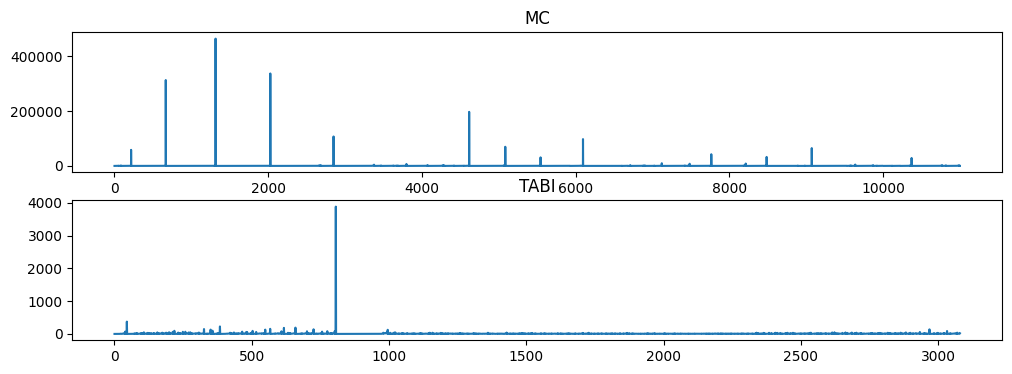

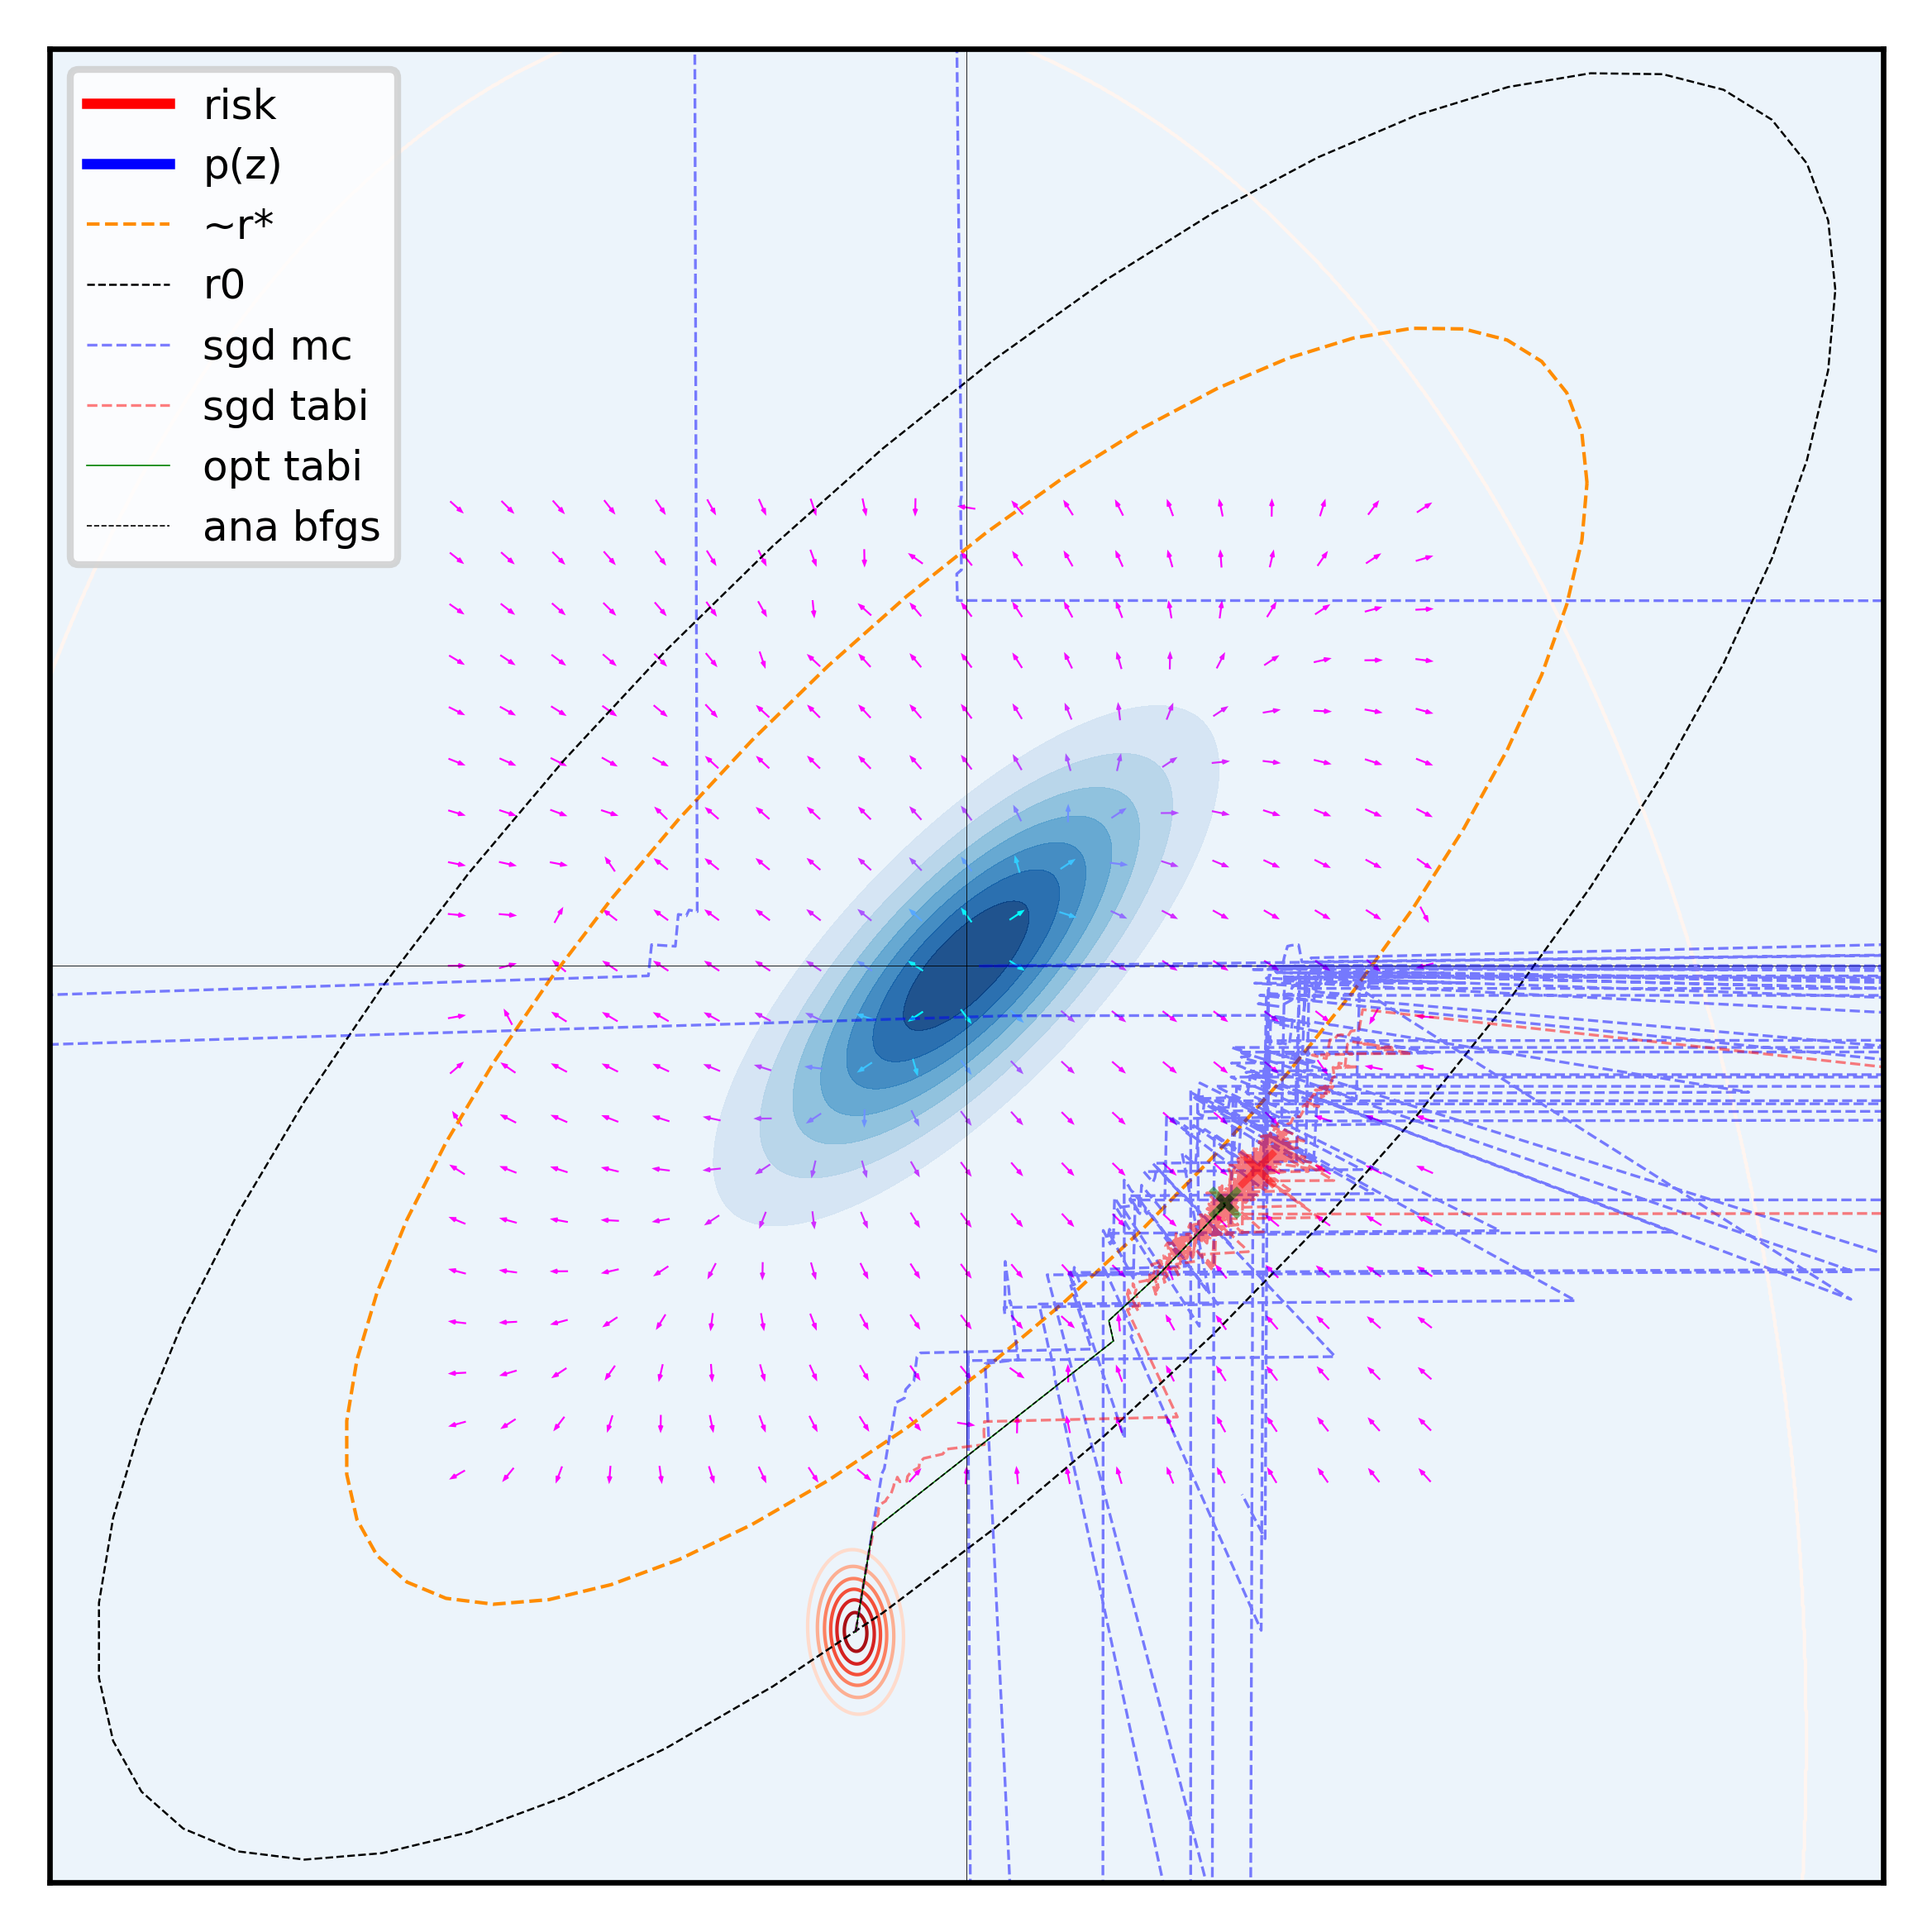

In [26]:
def example_problems():
    problem = generate_problem(q=0.1, n=2, rstar=5., theta0_rstar_delta=2.)
    _, err_axs = plt.subplots(2, 1, figsize=(12, 4))
    _, ax = plt.subplots(1, 1, dpi=600)
    visualize_problem(problem, ax, err_axs)
    # plt.tight_layout()
    plt.show()
example_problems()